# Image Deduplication with FiftyOne

This recipe demonstrates a simple use case of using FiftyOne to detect and
remove duplicate images from your dataset.

## Setup

If you haven't already, install FiftyOne:

In [ ]:
!pip install fiftyone

This notebook also requires the `tensorflow` package:

In [ ]:
!pip install tensorflow

## Download the data

First we download the dataset to disk. The dataset is a 1000 sample subset of
CIFAR-100, a dataset of 32x32 pixel images with one of 100 different
classification labels such as `apple`, `bicycle`, `porcupine`, etc. You can use this [helper script](https://raw.githubusercontent.com/voxel51/fiftyone/develop/docs/source/recipes/image_deduplication_helpers.py).

In [1]:
from image_deduplication_helpers import download_dataset

download_dataset()

	/tmp/fiftyone/cifar100_with_duplicates
and corrupting the data (5% duplicates)
Download successful


The above script uses `tensorflow.keras.datasets` to download the dataset, so
you must have [TensorFlow installed](https://www.tensorflow.org/install).

The dataset is organized on disk as follows:

```
/tmp/fiftyone/
└── cifar100_with_duplicates/
    ├── <classA>/
    │   ├── <image1>.jpg
    │   ├── <image2>.jpg
    │   └── ...
    ├── <classB>/
    │   ├── <image1>.jpg
    │   ├── <image2>.jpg
    │   └── ...
    └── ...
```

As we will soon come to discover, some of these samples are duplicates and we
have no clue which they are!

## Create a dataset

Let's start by importing the FiftyOne library:

In [2]:
import fiftyone as fo

Let's use a utililty method provided by FiftyOne to load the image
classification dataset from disk:

In [3]:
import os

dataset_name = "cifar100_with_duplicates"
dataset_dir = os.path.join("/tmp/fiftyone", dataset_name)

dataset = fo.Dataset.from_dir(
    dataset_dir,
    fo.types.ImageClassificationDirectoryTree,
    name=dataset_name
)

 100% |████████████| 1000/1000 [1.2s elapsed, 0s remaining, 718.5 samples/s]         


## Explore the dataset

We can poke around in the dataset:

In [4]:
# Print summary information about the dataset
print(dataset)

Name:           cifar100_with_duplicates
Media type:     image
Num samples:    1000
Persistent:     False
Info:           {'classes': ['apple', 'aquarium_fish', 'baby', ...]}
Tags:           []
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [5]:
# Print a sample
print(dataset.first())

<Sample: {
    'id': '5ff8dc665b5b9368e094de5a',
    'media_type': 'image',
    'filepath': '/tmp/fiftyone/cifar100_with_duplicates/apple/113.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8dc665b5b9368e094de59',
        'label': 'apple',
        'confidence': None,
        'logits': None,
    }>,
}>


Create a view that contains only samples whose ground truth label is
`mountain`:

In [6]:
# Used to write view expressions that involve sample fields
from fiftyone import ViewField as F

view = dataset.match(F("ground_truth.label") == "mountain")

# Print summary information about the view
print(view)

Dataset:        cifar100_with_duplicates
Media type:     image
Num samples:    8
Tags:           []
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. Match(filter={'$expr': {'$eq': [...]}})


In [7]:
# Print the first sample in the view
print(view.first())

<SampleView: {
    'id': '5ff8dc675b5b9368e094e436',
    'media_type': 'image',
    'filepath': '/tmp/fiftyone/cifar100_with_duplicates/mountain/0.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8dc675b5b9368e094e435',
        'label': 'mountain',
        'confidence': None,
        'logits': None,
    }>,
}>


Create a view with samples sorted by their ground truth labels in reverse
alphabetical order:

In [8]:
view = dataset.sort_by("ground_truth", reverse=True)

# Print summary information about the view
print(view)

Dataset:        cifar100_with_duplicates
Media type:     image
Num samples:    1000
Tags:           []
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. SortBy(field_or_expr='ground_truth', reverse=True)


In [9]:
# Print the first sample in the view
print(view.first())

<SampleView: {
    'id': '5ff8dc685b5b9368e094ea0f',
    'media_type': 'image',
    'filepath': '/tmp/fiftyone/cifar100_with_duplicates/worm/905.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8dc685b5b9368e094ea0e',
        'label': 'worm',
        'confidence': None,
        'logits': None,
    }>,
}>


## Visualize the dataset

Start browsing the dataset:


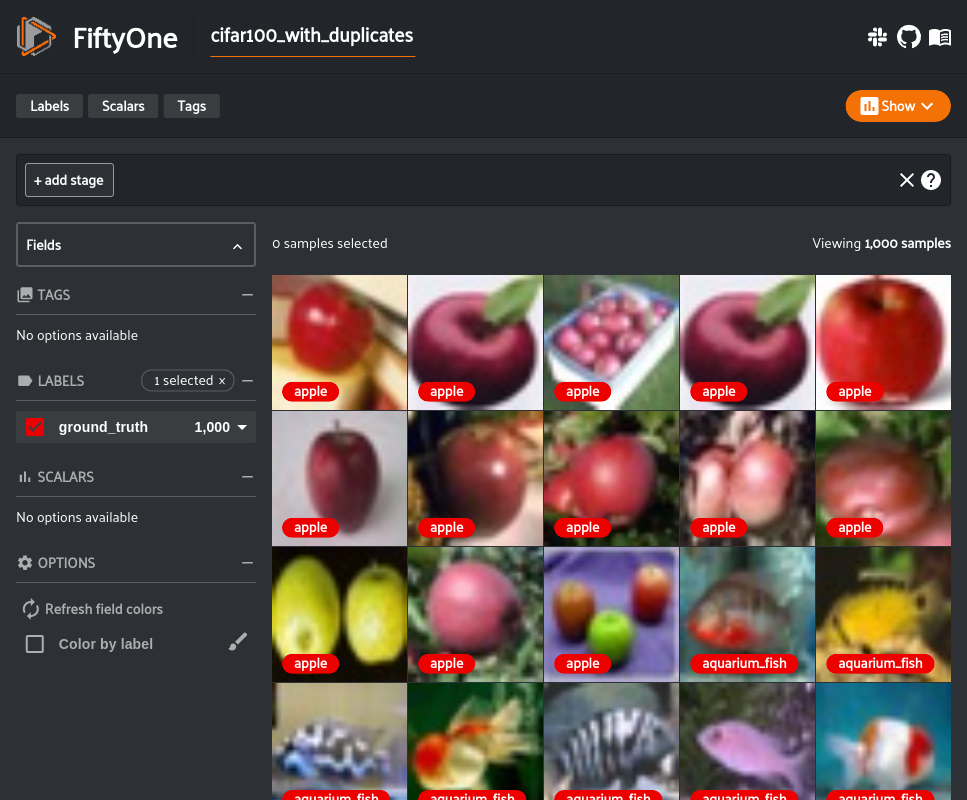

In [10]:
session = fo.launch_app(dataset)

Narrow your scope to 10 random samples:


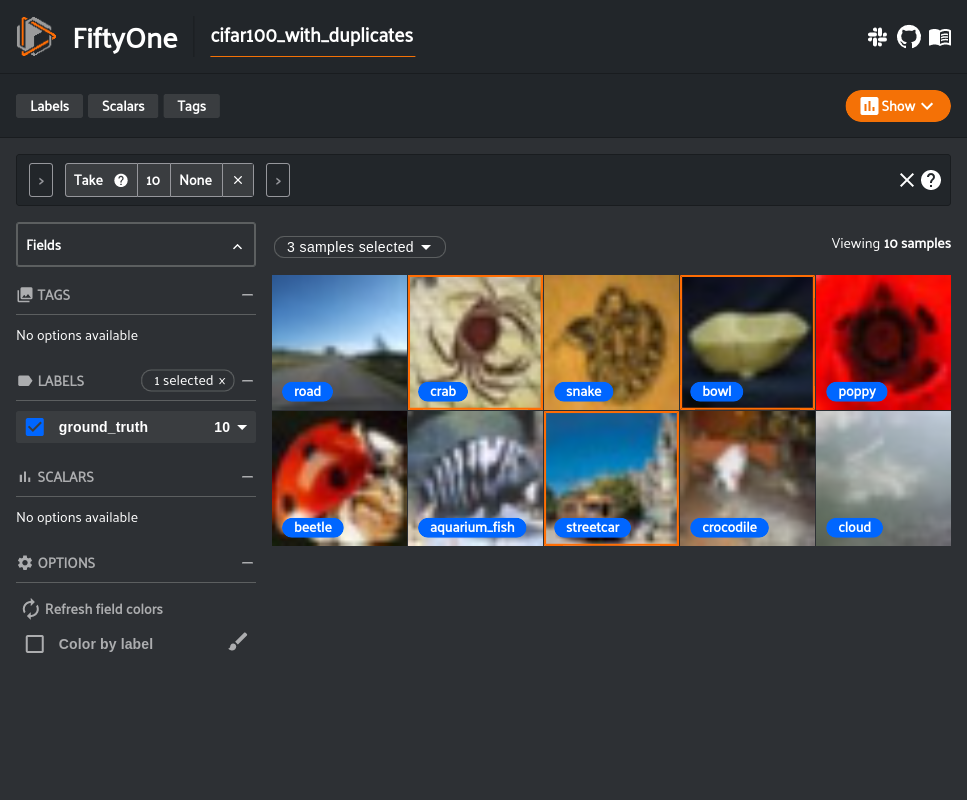

In [11]:
session.view = dataset.take(10)

Click on some some samples in the App to select them and access their IDs from
code!

In [12]:
# Get the IDs of the currently selected samples in the App
sample_ids = session.selected

Create a view that contains your currently selected samples:

In [13]:
selected_view = dataset.select(session.selected)

Update the App to only show your selected samples:


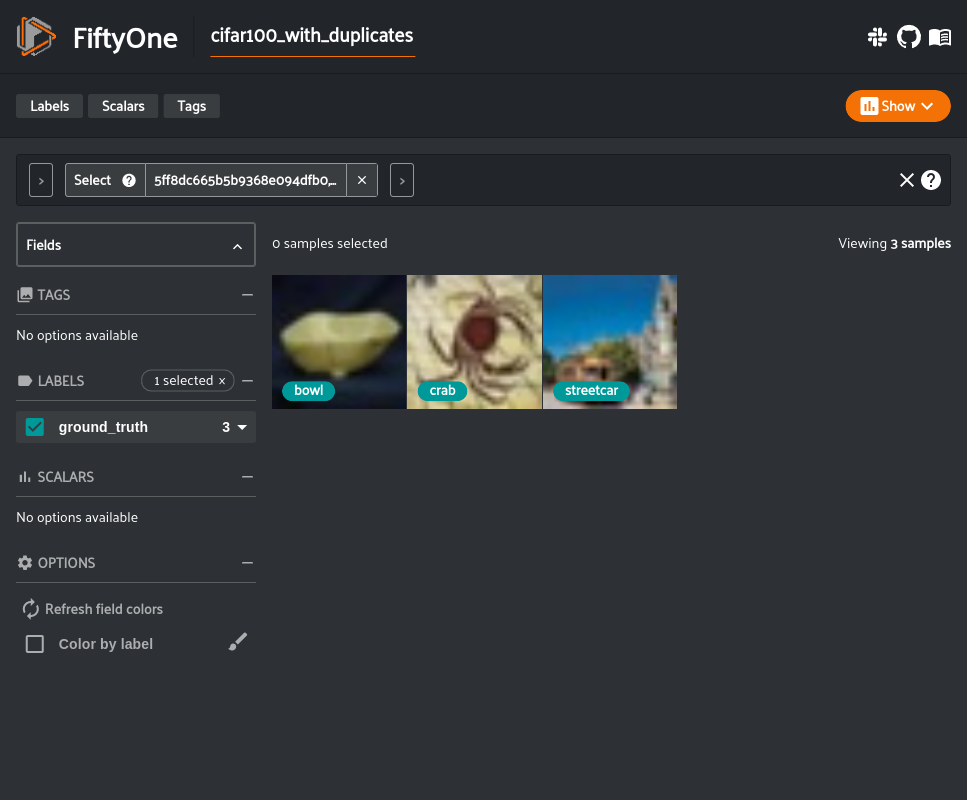

In [14]:
session.view = selected_view

## Compute file hashes

Iterate over the samples and compute their file hashes:

In [15]:
import fiftyone.core.utils as fou

for sample in dataset:
    sample["file_hash"] = fou.compute_filehash(sample.filepath)
    sample.save()

print(dataset)

Name:           cifar100_with_duplicates
Media type:     image
Num samples:    1000
Persistent:     False
Info:           {'classes': ['apple', 'aquarium_fish', 'baby', ...]}
Tags:           []
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    file_hash:    fiftyone.core.fields.IntField


We have two ways to visualize this new information.

First, you can view the sample from your Terminal:

In [16]:
sample = dataset.first()
print(sample)

<Sample: {
    'id': '5ff8dc665b5b9368e094de5a',
    'media_type': 'image',
    'filepath': '/tmp/fiftyone/cifar100_with_duplicates/apple/113.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8dc665b5b9368e094de59',
        'label': 'apple',
        'confidence': None,
        'logits': None,
    }>,
    'file_hash': -6346202338154836458,
}>


Or you can refresh the App and toggle on the new `file_hash` field:


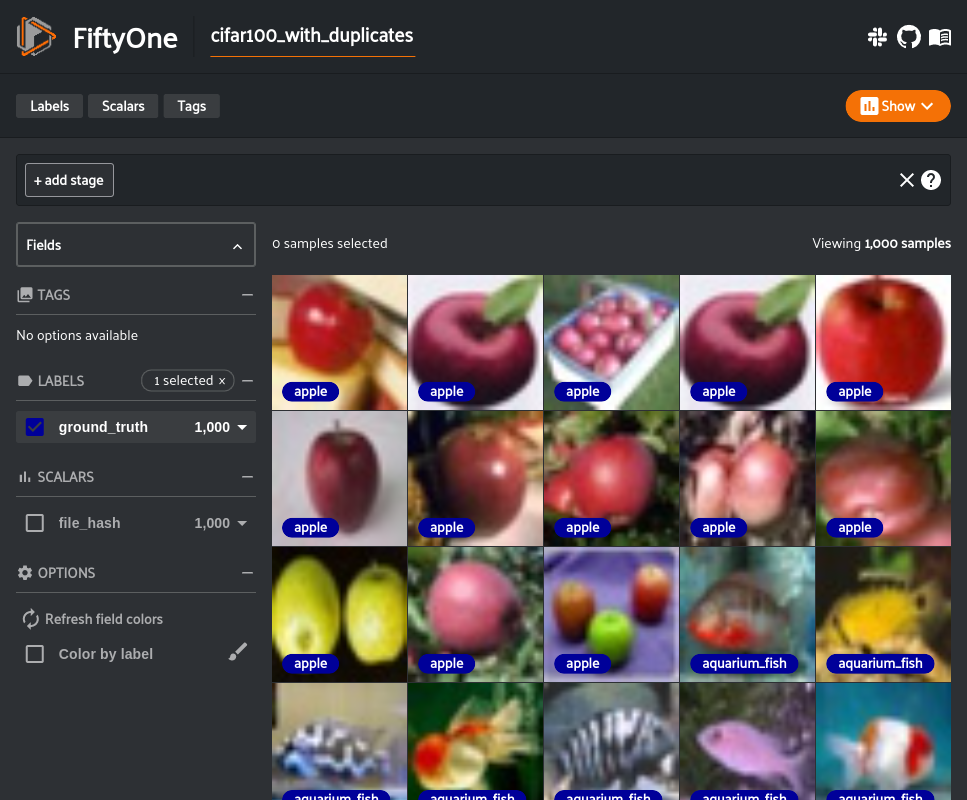

In [17]:
session.dataset = dataset

## Check for duplicates

Now let's use a simple Python statement to locate the duplicate files in the
dataset, i.e., those with the same file hashses:

In [18]:
from collections import Counter

filehash_counts = Counter(sample.file_hash for sample in dataset)
dup_filehashes = [k for k, v in filehash_counts.items() if v > 1]

print("Number of duplicate file hashes: %d" % len(dup_filehashes))

Number of duplicate file hashes: 36


Now let's create a view that contains only the samples with these duplicate
file hashes:

In [19]:
dup_view = (dataset
    # Extract samples with duplicate file hashes
    .match(F("file_hash").is_in(dup_filehashes))
    # Sort by file hash so duplicates will be adjacent
    .sort_by("file_hash")
)

print("Number of images that have a duplicate: %d" % len(dup_view))
print("Number of duplicates: %d" % (len(dup_view) - len(dup_filehashes)))

Number of images that have a duplicate: 72
Number of duplicates: 36


Of course, we can always use the App to visualize our work!


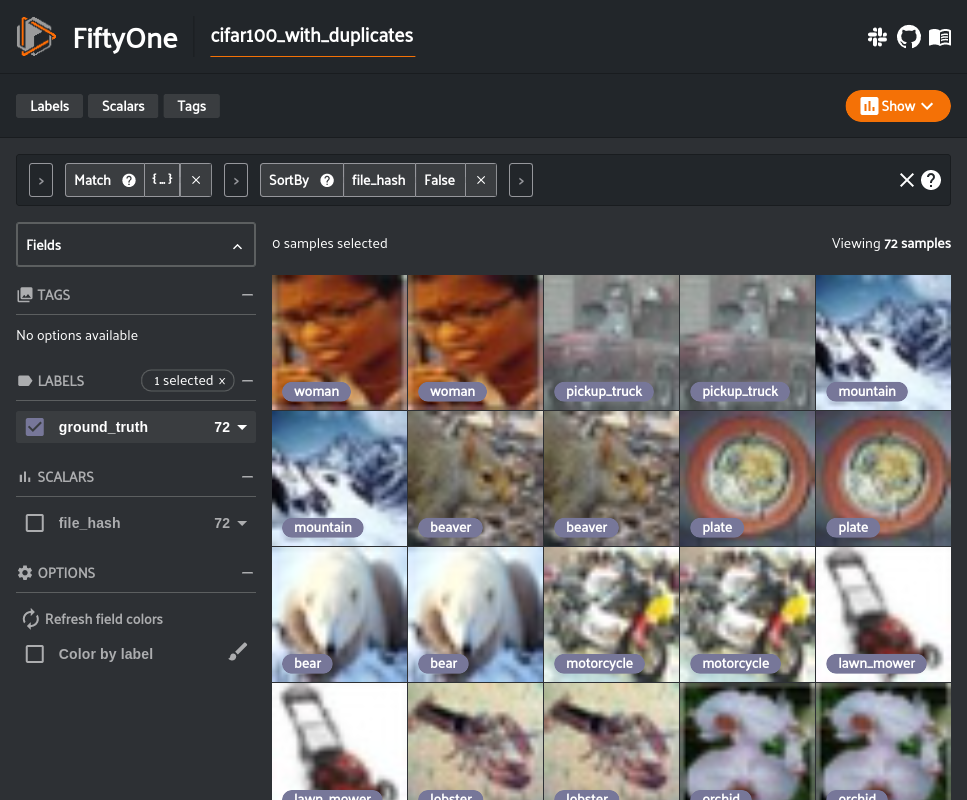

In [20]:
session.view = dup_view

## Delete duplicates

Now let's delete the duplicate samples from the dataset using our `dup_view` to
restrict our attention to known duplicates:

In [21]:
print("Length of dataset before: %d" % len(dataset))

_dup_filehashes = set()
for sample in dup_view:
    if sample.file_hash not in _dup_filehashes:
        _dup_filehashes.add(sample.file_hash)
        continue

    del dataset[sample.id]

print("Length of dataset after: %d" % len(dataset))

# Verify that the dataset no longer contains any duplicates
print("Number of unique file hashes: %d" % len({s.file_hash for s in dataset}))

Length of dataset before: 1000
Length of dataset after: 964
Number of unique file hashes: 964


## Export the deduplicated dataset

Finally, let's export a fresh copy of our now-duplicate-free dataset:

In [22]:
EXPORT_DIR = "/tmp/fiftyone/image-deduplication"
dataset.export

dataset.export(label_field="ground_truth", export_dir=EXPORT_DIR, dataset_type=fo.types.FiftyOneImageClassificationDataset,)

 100% |████████████| 964/964 [408.8ms elapsed, 0s remaining, 2.4K samples/s]      


Check out the contents of `/tmp/fiftyone/image-deduplication` on disk to see how the data is
organized.

You can load the deduplicated dataset that you exported back into FiftyOne at
any time as follows:

In [23]:
no_dups_dataset = fo.Dataset.from_dir(
    EXPORT_DIR,
    fo.types.FiftyOneImageClassificationDataset,
    name="no_duplicates",
)

print(no_dups_dataset)

 100% |████████████| 964/964 [1.1s elapsed, 0s remaining, 838.4 samples/s]         
Name:           no_duplicates
Media type:     image
Num samples:    964
Persistent:     False
Info:           {'classes': ['apple', 'aquarium_fish', 'baby', ...]}
Tags:           []
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


## Cleanup

You can cleanup the files generated by this recipe by running:

In [28]:
!rm -rf /tmp/fiftyone

In [24]:
session.freeze() # screenshot the active App for sharing